# Playground

## Design Data Preprocessing 

In [1]:
import wfdb
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt

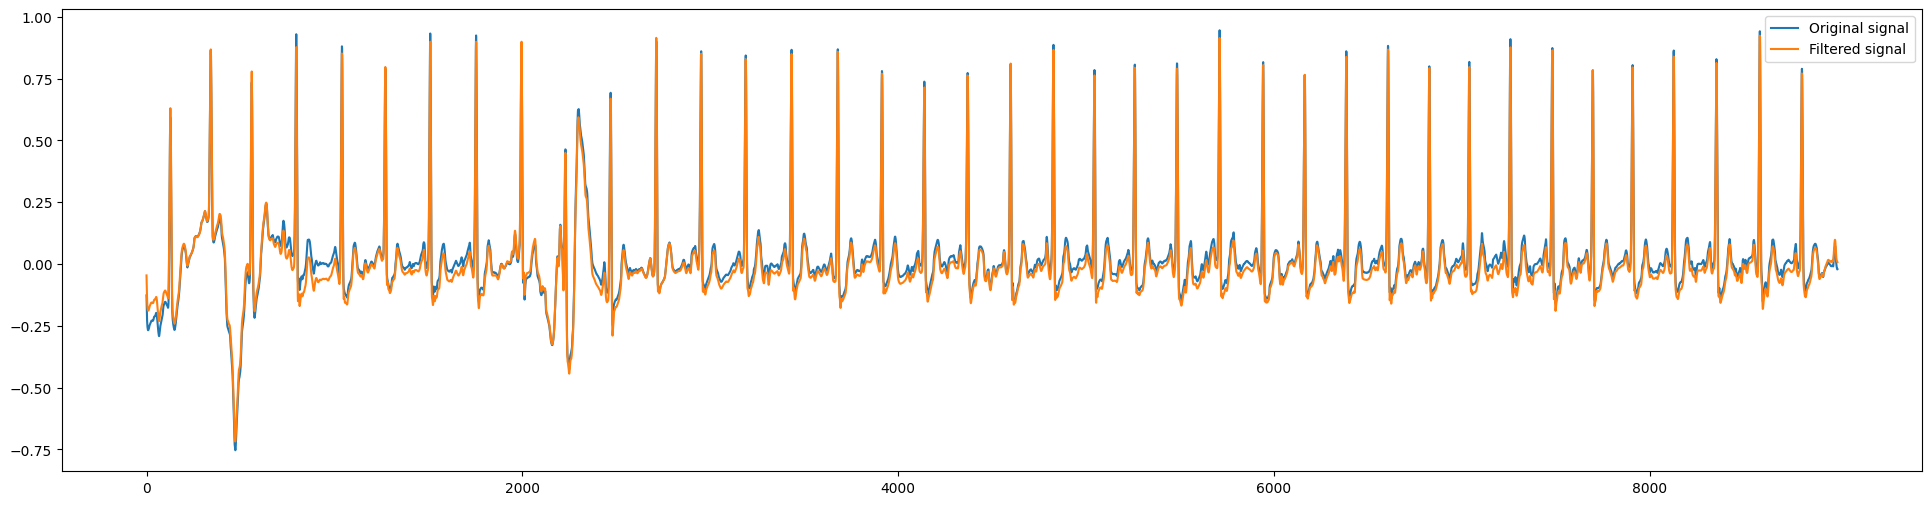

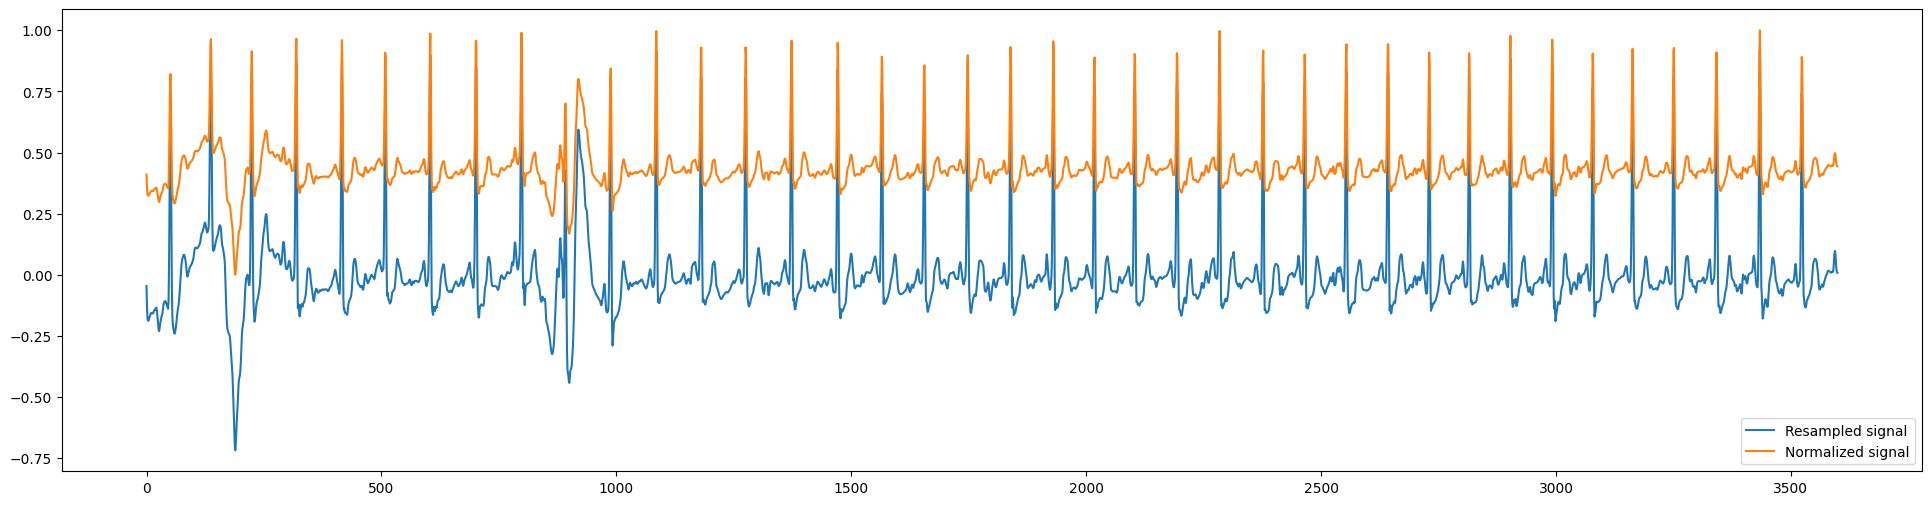

In [2]:
from dataset_utils.transforms import MinMaxNorm

signal, _ = wfdb.rdsamp("dataset/training2017/A00001")  # min: A04894; max: A06471
signal = np.squeeze(signal)

filtered_signal = nk.signal_filter(
    signal,
    sampling_rate=300,
    lowcut=0.5,
    highcut=40,
    method="butter",
    order=6,
)
resampled_signal = nk.signal_resample(
    filtered_signal, sampling_rate=300, desired_sampling_rate=120
)

min_max_norm = MinMaxNorm()
min_max_norm_signal = min_max_norm(resampled_signal)

pd.Series(signal).plot(figsize=(24, 6), label="Original signal")
pd.Series(filtered_signal).plot(figsize=(24, 6), label="Filtered signal")
plt.legend()
plt.show()

pd.Series(resampled_signal).plot(figsize=(24, 6), label="Resampled signal")
pd.Series(min_max_norm_signal).plot(figsize=(24, 6), label="Normalized signal")
plt.legend()
plt.show()

## Check Data Transforms

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataset_utils.transforms import (
    RandomTimeScale,
    RandomNoise,
    RandomInvert,
    RandomMask,
)

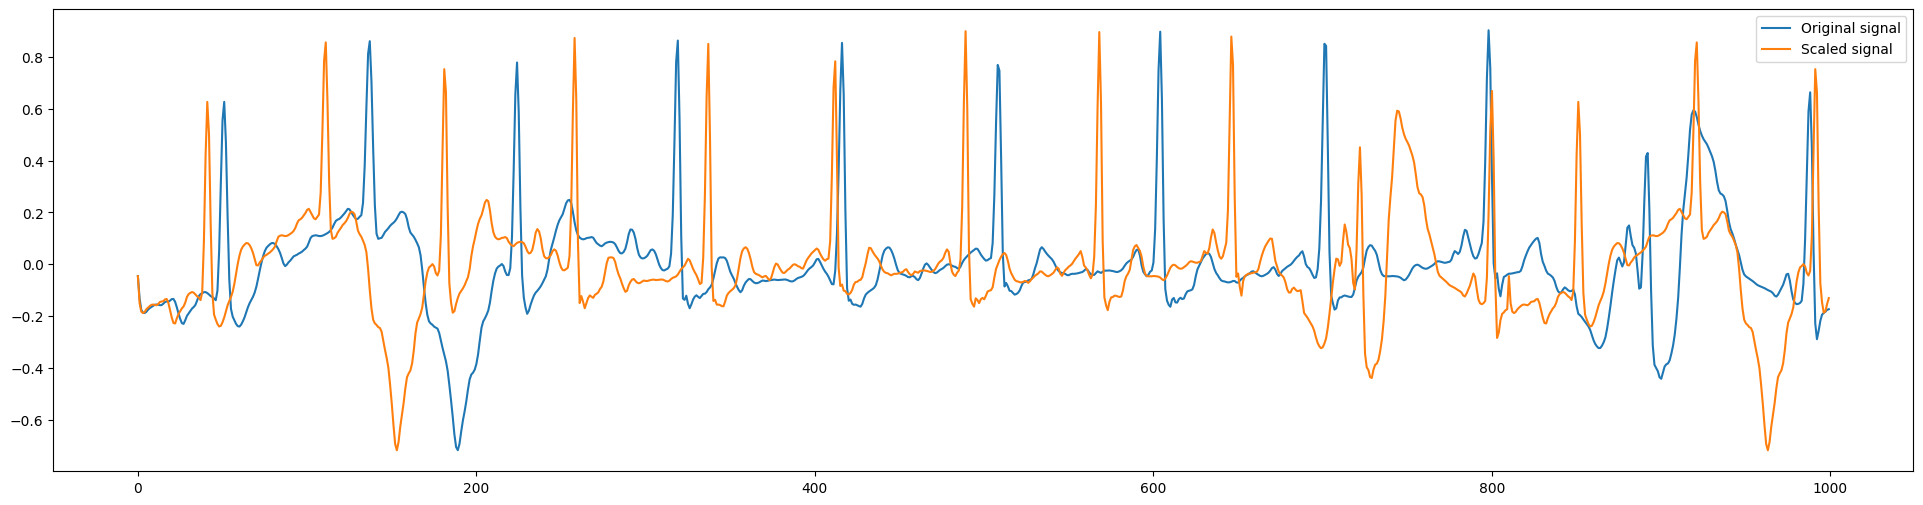

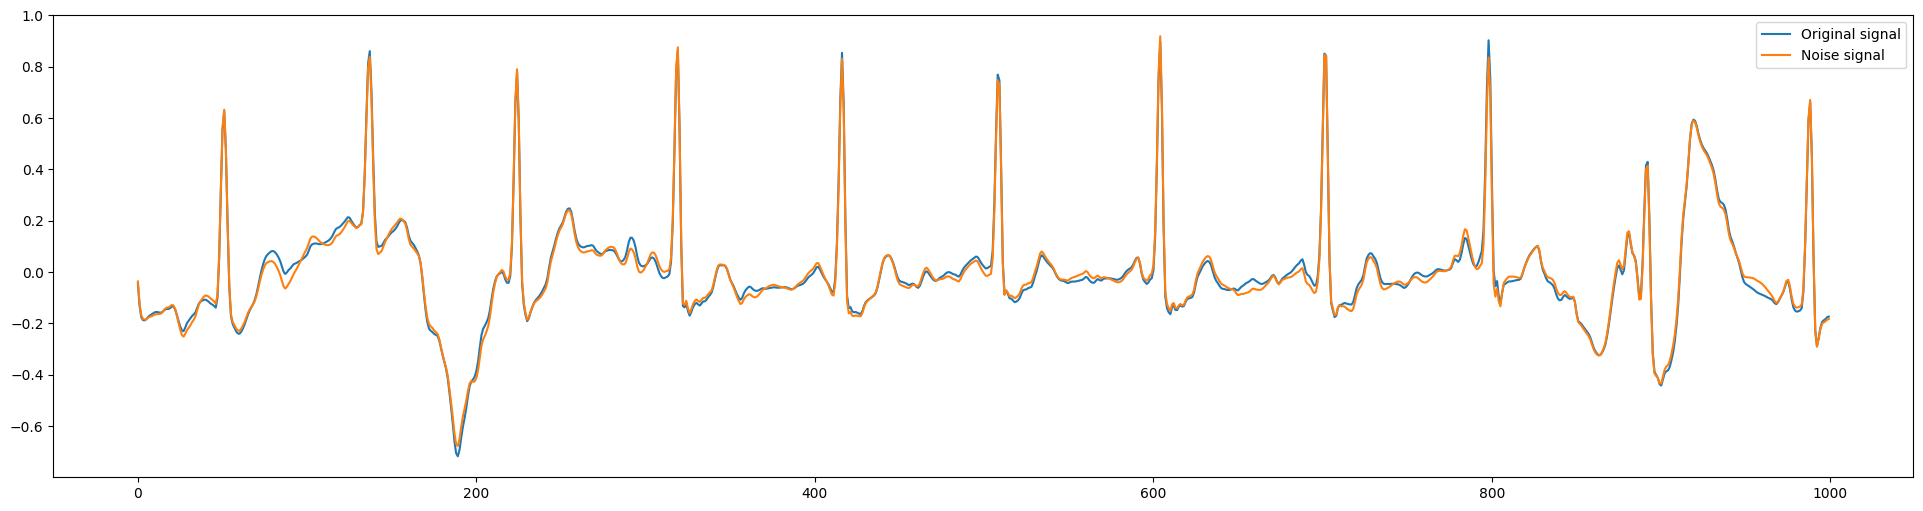

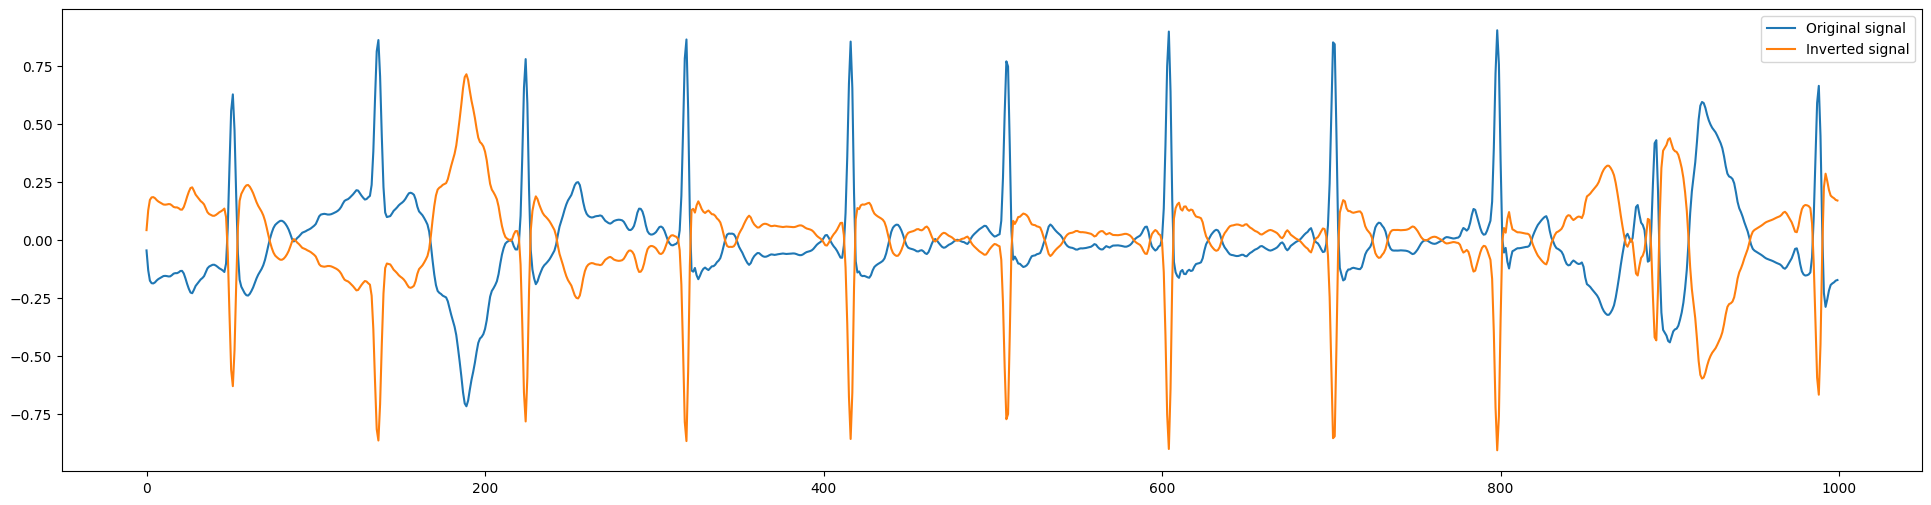

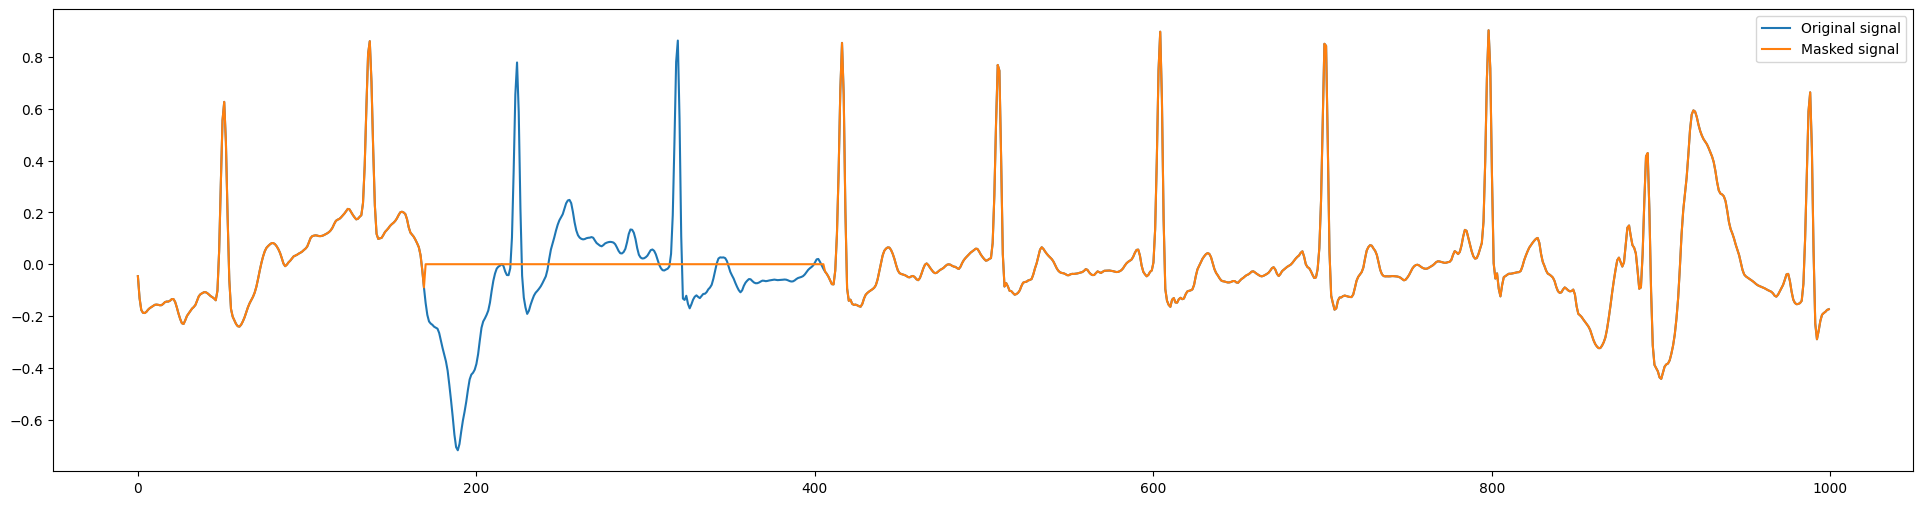

In [4]:
signal = np.loadtxt("dataset/preprocessed/A00001.csv")[:1000]

random_scale = RandomTimeScale(factor=0.3, p=1)
random_noise = RandomNoise(signal_freq=120, noise_amplitude=0.1, noise_freq=12, p=1)
random_invert = RandomInvert(signal_freq=120, p=1)
random_mask = RandomMask(ratio_from=0.1, ratio_to=0.3, p=1)

scaled_signal = random_scale(signal)
noise_signal = random_noise(signal)
inverted_signal = random_invert(signal)
masked_signal = random_mask(signal)

pd.Series(signal).plot(figsize=(24, 6), label="Original signal")
pd.Series(scaled_signal).plot(figsize=(24, 6), label="Scaled signal")
plt.legend()
plt.show()

pd.Series(signal).plot(figsize=(24, 6), label="Original signal")
pd.Series(noise_signal).plot(figsize=(24, 6), label="Noise signal")
plt.legend()
plt.show()

pd.Series(signal).plot(figsize=(24, 6), label="Original signal")
pd.Series(inverted_signal).plot(figsize=(24, 6), label="Inverted signal")
plt.legend()
plt.show()

pd.Series(signal).plot(figsize=(24, 6), label="Original signal")
pd.Series(masked_signal).plot(figsize=(24, 6), label="Masked signal")
plt.legend()
plt.show()

## Check Data Augmentation

In [5]:
import pandas as pd
from dataset_utils import Cinc2017DataModule

data_module = Cinc2017DataModule()
data_module.setup("fit")

<Axes: >

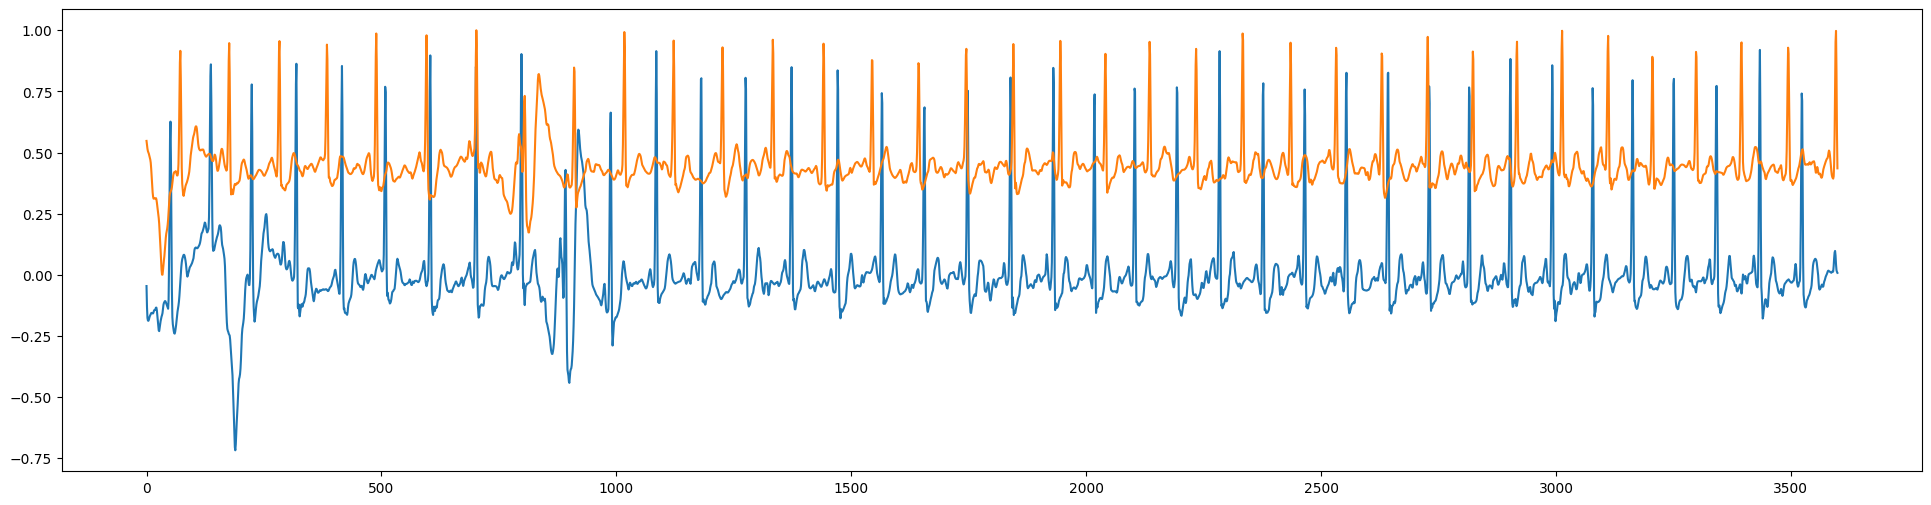

In [6]:
signal = data_module.train_set.signals[0]
signal_aug = data_module.train_set[0][0]
pd.Series(signal).plot(figsize=(24, 6))
pd.Series(signal_aug[0]).plot(figsize=(24, 6))

## NON-IID Dataset Partitioning

In [2]:
from dataset_utils import Cinc2017Dataset
from flwr_datasets.partitioner import DirichletPartitioner
from datasets import Dataset, ClassLabel
from flwr_datasets.visualization import plot_label_distributions

/home/g113056077/.pyenv/versions/ecg-fl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
client_set = Cinc2017Dataset("train")

In [4]:
data = {"signal": client_set.signals, "label": client_set.labels}
dataset = Dataset.from_dict(data)
dataset = dataset.cast_column(
    "label", ClassLabel(names=client_set.classes)
)

Casting the dataset: 100%|██████████| 6599/6599 [00:00<00:00, 41581.60 examples/s]


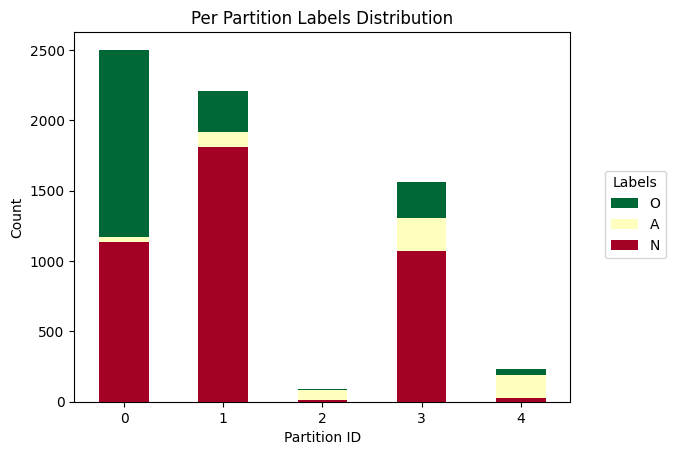

In [7]:
client_set_partitioner = DirichletPartitioner(
    num_partitions=5,
    partition_by="label",
    alpha=0.5,
    seed=42,
)

client_set_partitioner.dataset = dataset

fig, ax, df = plot_label_distributions(
    client_set_partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    title="Per Partition Labels Distribution",
)